# Detección de Recaídas de Cáncer de Tiroides

## Configuración del entorno

Primero se importa todas las librerias de la biblioteca de Scikit-Learn que son necesarias para llevar a cabo el estudio.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Importación de los datos

Se importa el dataset con el que se van a entrenar los modelos de clasificación y se visualiza su estructura y tipo de dato.

In [2]:
df = pd.read_csv("Cancer_Tiroides.csv")

In [3]:
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   345 non-null    int64 
 1   Gender                345 non-null    object
 2   Smoking               345 non-null    object
 3   Hx Smoking            345 non-null    object
 4   Hx Radiothreapy       345 non-null    object
 5   Thyroid Function      345 non-null    object
 6   Physical Examination  345 non-null    object
 7   Adenopathy            345 non-null    object
 8   Pathology             345 non-null    object
 9   Focality              345 non-null    object
 10  Risk                  345 non-null    object
 11  T                     345 non-null    object
 12  N                     345 non-null    object
 13  M                     345 non-null    object
 14  Stage                 345 non-null    object
 15  Response              345 non-null    ob

<br>

## Análisis exploratorio de los datos(EDA)

### Resumen estadístico

A continuación, se resumen los datos de cada columna de forma visual con histogramas y estadística para conocer cómo se distribuyen los datos en cada característica.

#### De forma gráfica

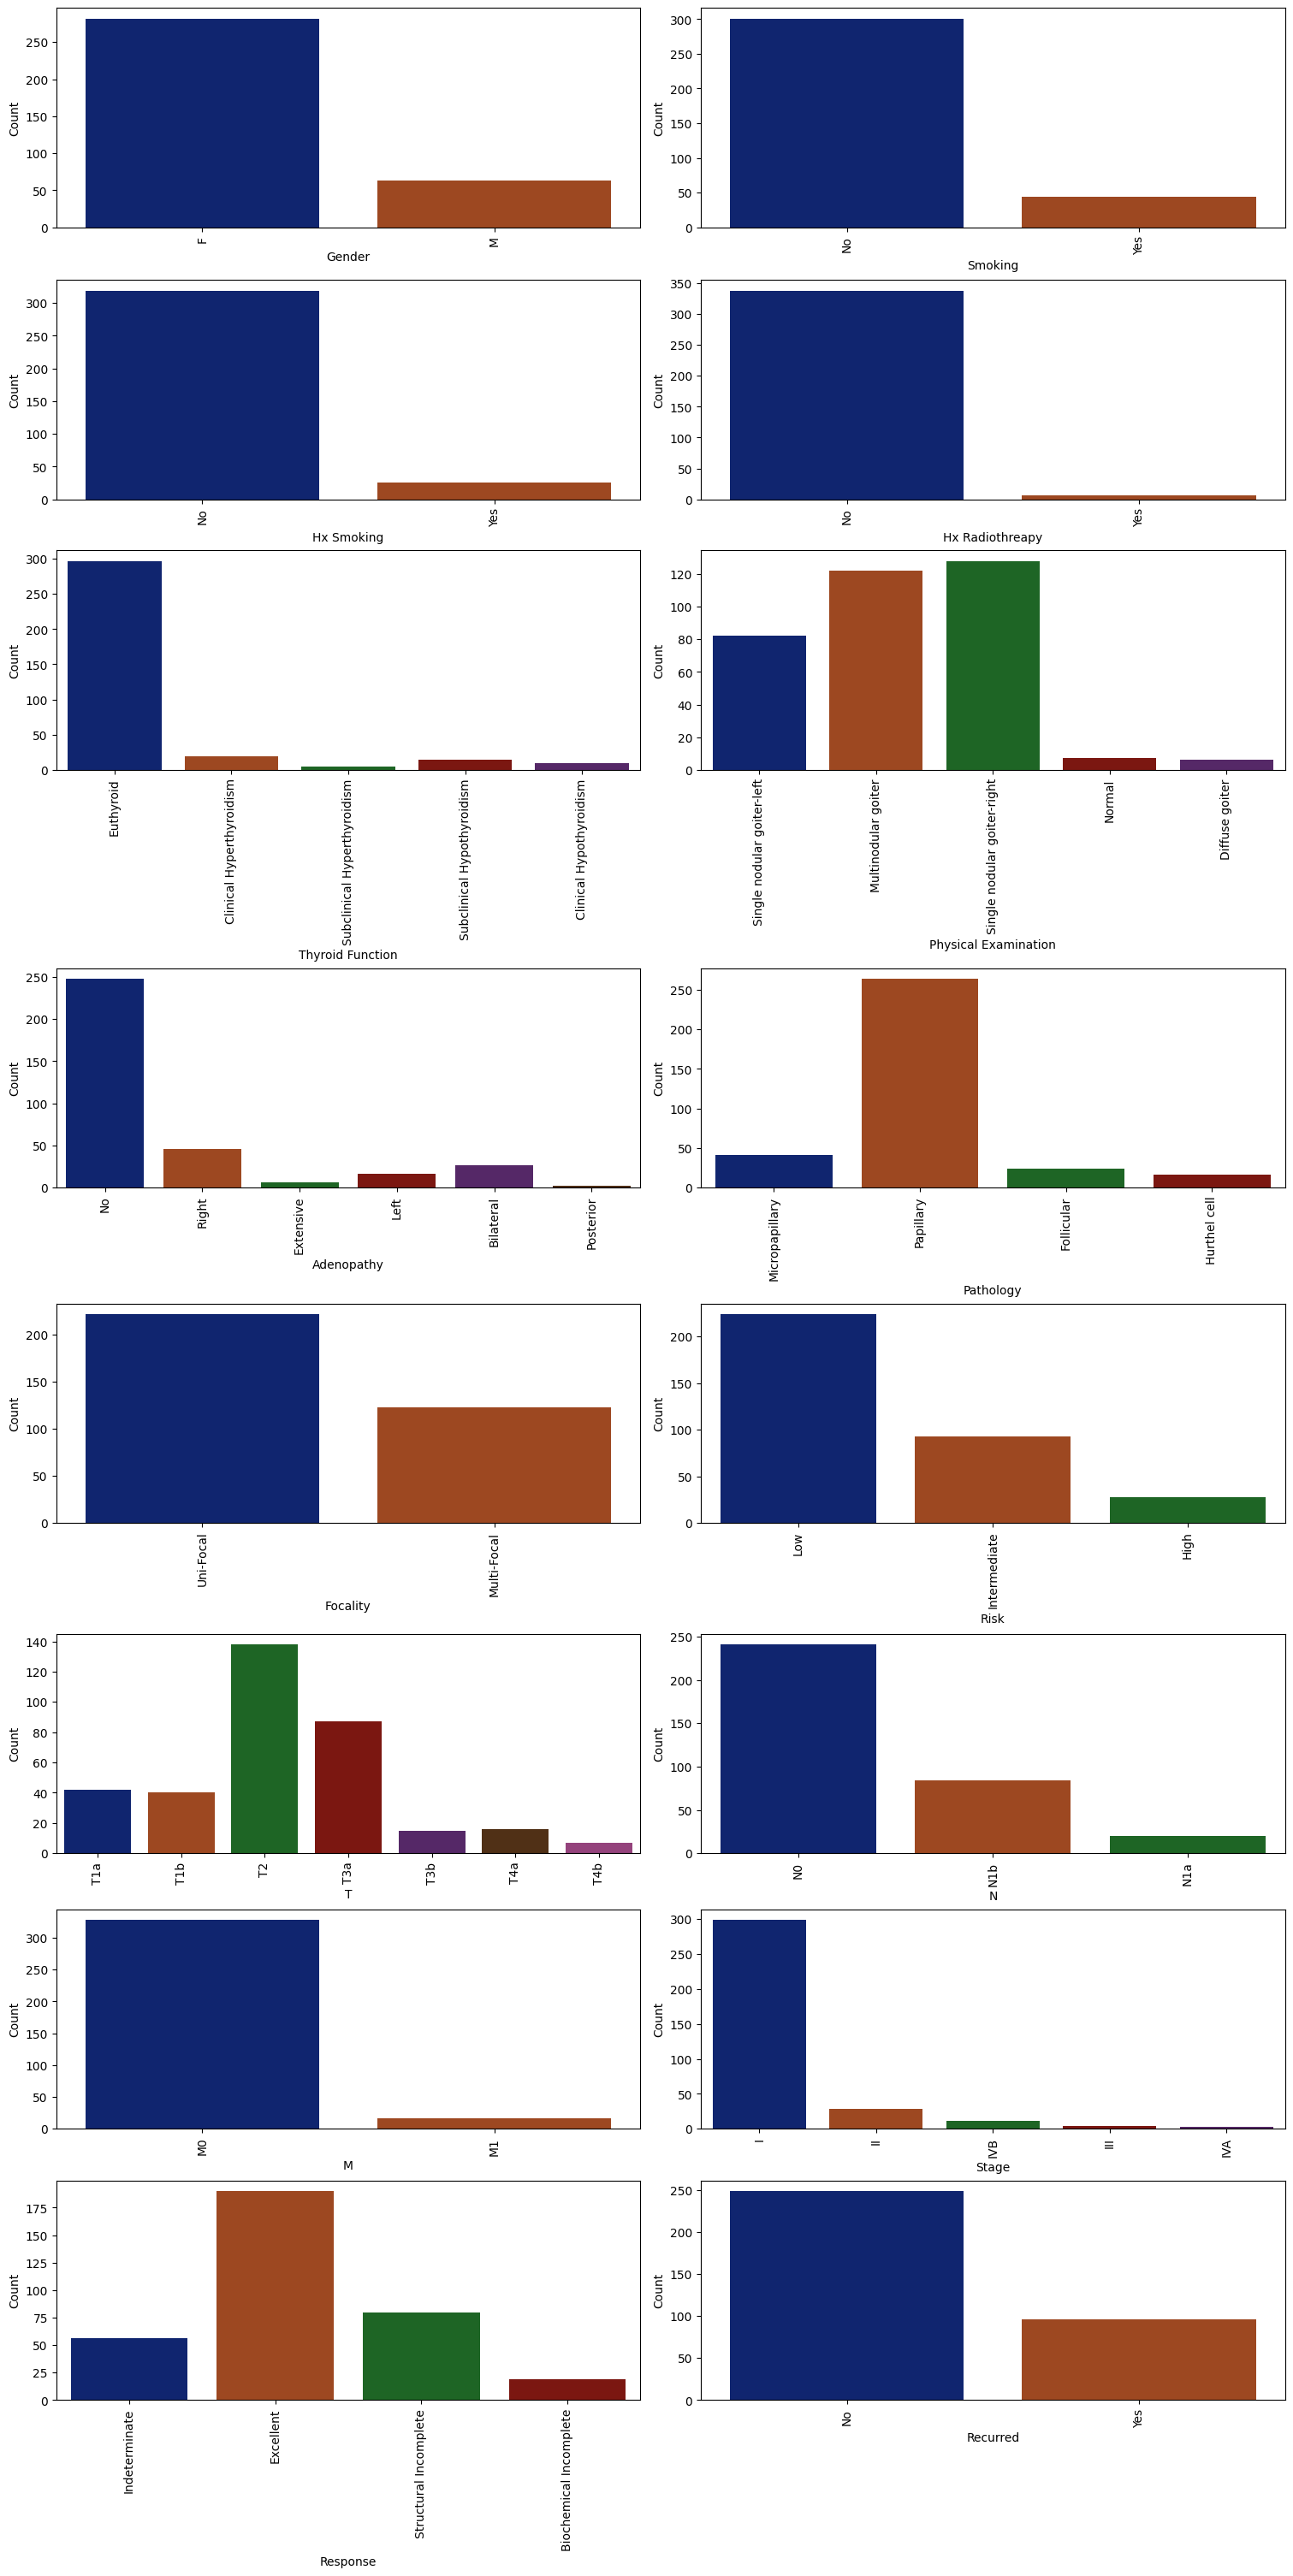

In [5]:
# Se separan las variables categóricas de las númericas
cat_features = df.columns[1:]

fig, ax= plt.subplots(8, 2, figsize=(15, 30), constrained_layout = True)
ax = ax.flat

for i, cat in enumerate(cat_features):
    sns.countplot(x=cat, data=df, palette="dark", ax=ax[i])
    ax[i].set_xlabel(cat)
    ax[i].set_ylabel('Count')
    ax[i].tick_params(axis='x', rotation=90)


<Axes: xlabel='Age', ylabel='Count'>

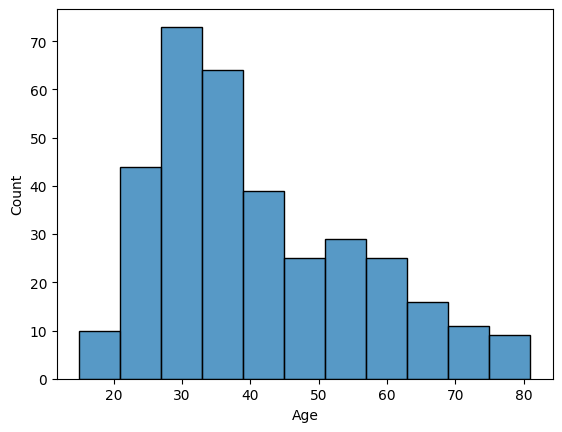

In [6]:
sns.histplot(df["Age"], palette="dark")

#### Codificar variables categóricas en numéricas

Se codifican las variables categóricas que son todas las columnas excepto 'Age' para calcular sus estadísticos y poder entrenar los algoritmos posteriormente. Para no modificar los datos originales del dataset, se crea una copia del dataframe y en este codifican las variables con `LabelEncoder`.

In [7]:
df_copy = df.copy()

# Separamos las variables categóricas de las númericas
cat_features = df.columns[1:]

le = LabelEncoder()

for i in cat_features:
    df_copy[i] = le.fit_transform(df[i])

In [8]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   345 non-null    int64
 1   Gender                345 non-null    int32
 2   Smoking               345 non-null    int32
 3   Hx Smoking            345 non-null    int32
 4   Hx Radiothreapy       345 non-null    int32
 5   Thyroid Function      345 non-null    int32
 6   Physical Examination  345 non-null    int32
 7   Adenopathy            345 non-null    int32
 8   Pathology             345 non-null    int32
 9   Focality              345 non-null    int32
 10  Risk                  345 non-null    int32
 11  T                     345 non-null    int32
 12  N                     345 non-null    int32
 13  M                     345 non-null    int32
 14  Stage                 345 non-null    int32
 15  Response              345 non-null    int32
 16  Recurred

#### De forma tabular

In [9]:
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,345.0,40.742029,15.096400,15.0,29.0,37.0,51.0,81.0
Gender,345.0,0.182609,0.386907,0.0,0.0,0.0,0.0,1.0
Smoking,345.0,0.127536,0.334057,0.0,0.0,0.0,0.0,1.0
Hx Smoking,345.0,0.075362,0.264358,0.0,0.0,0.0,0.0,1.0
Hx Radiothreapy,345.0,0.020290,0.141195,0.0,0.0,0.0,0.0,1.0
Thyroid Function,345.0,1.956522,0.652250,0.0,2.0,2.0,2.0,4.0
Physical Examination,345.0,2.591304,1.341829,0.0,1.0,3.0,4.0,4.0
Adenopathy,345.0,2.956522,1.166823,0.0,3.0,3.0,3.0,5.0
Pathology,345.0,2.579710,0.869473,0.0,3.0,3.0,3.0,3.0
Focality,345.0,0.643478,0.479667,0.0,0.0,1.0,1.0,1.0


### Comprobar la relación entre caracterísitcas

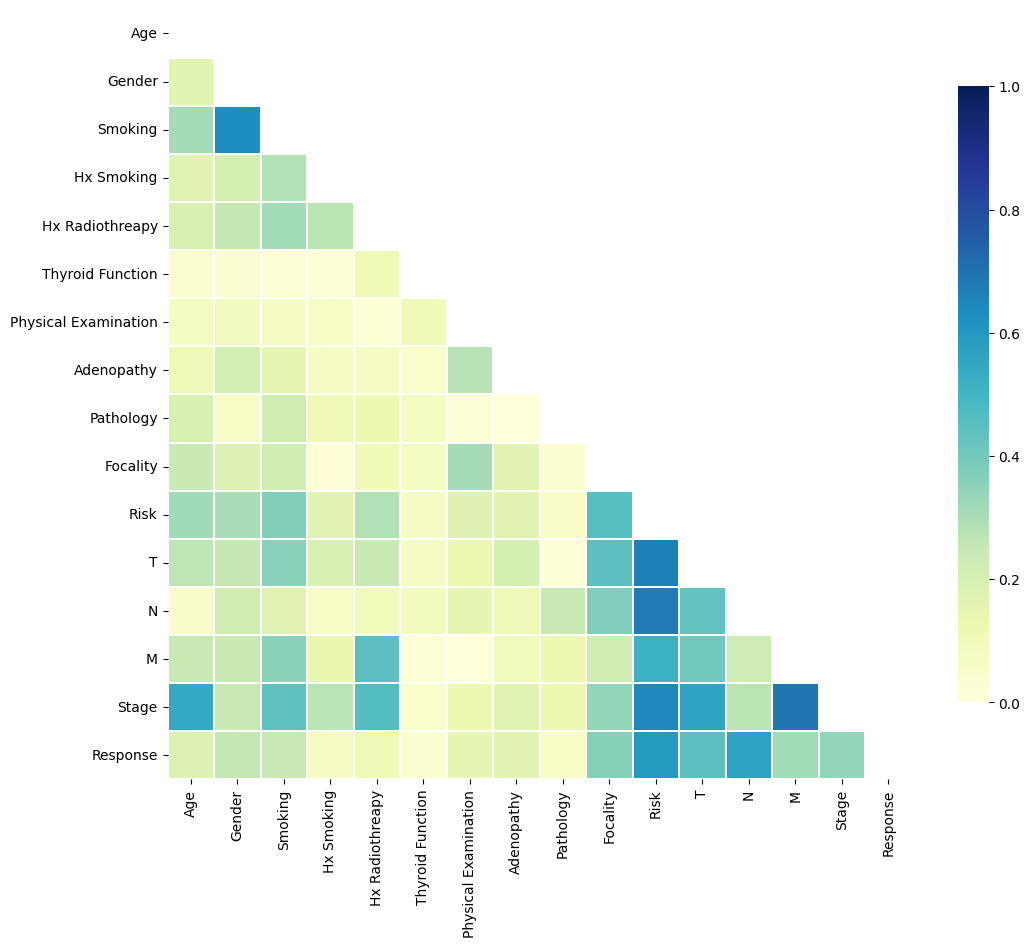

In [10]:
corr = np.abs(df_copy.drop(['Recurred'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

## Preparar los datos para los algoritmos de aprendizaje automático

### Investigar si hay datos pérdidos

In [11]:
df.isnull().sum()

Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64

### Comprobar si exiten datos atípicos

Se comprueba de manera gráfica con diagramas de cajas y bigotes si hay datos atípicos en cada columna.

<Axes: >

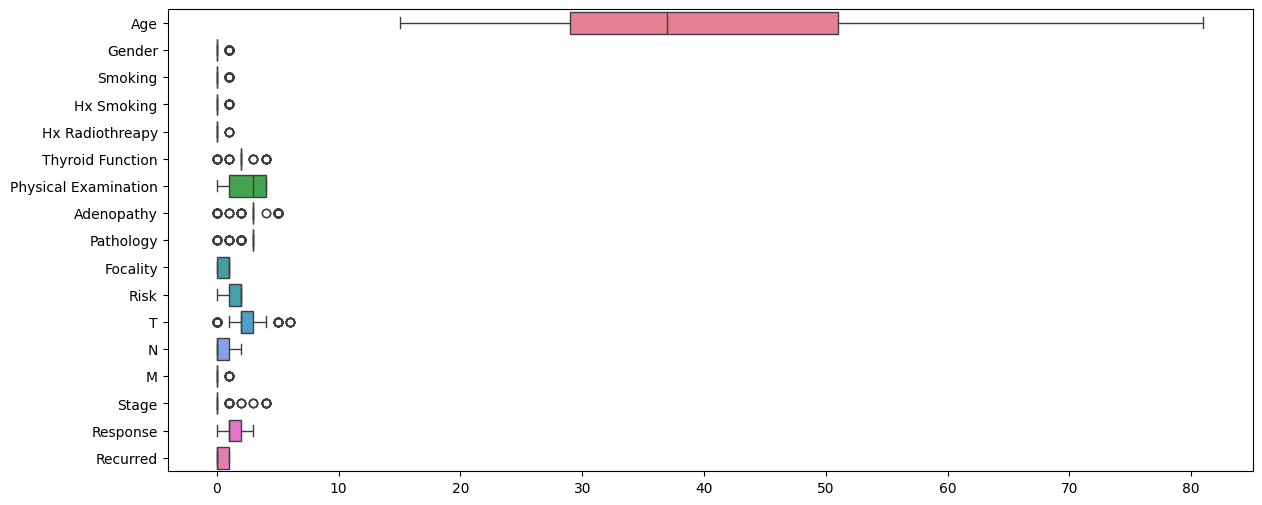

In [12]:
plt.figure(figsize=(14, 6))
sns.boxplot(df_copy, orient='h')

La función `counting_outliers` calcula el porcentaje de valores atípicos en una columna de un dataframe.

In [13]:
def counting_outliers(df, column):
    Q1, Q3 = np.percentile(df[column], [25, 75])
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR

    outliers = (df[column] < lower) | (df[column] > upper)

    count = outliers.sum()
    percentage = (count / len(df)) * 100
    return percentage

Con un `for` se aplica la función `counting_outliers` a cada columna para conocer el porencaje de outliers de esta. En este caso, ninguna variable tiene más del 50% de datos atípicos, por lo que se ha decidido conservar todos ellos.

In [14]:
for column in df_copy.columns:
    porcentaje_outliers = counting_outliers(df_copy, column)
    print(f'El porcentaje de outliers en {column} es: {porcentaje_outliers}%')

El porcentaje de outliers en Age es: 0.0%
El porcentaje de outliers en Gender es: 18.26086956521739%
El porcentaje de outliers en Smoking es: 12.753623188405797%
El porcentaje de outliers en Hx Smoking es: 7.536231884057972%
El porcentaje de outliers en Hx Radiothreapy es: 2.0289855072463765%
El porcentaje de outliers en Thyroid Function es: 13.91304347826087%
El porcentaje de outliers en Physical Examination es: 0.0%
El porcentaje de outliers en Adenopathy es: 28.115942028985508%
El porcentaje de outliers en Pathology es: 23.47826086956522%
El porcentaje de outliers en Focality es: 0.0%
El porcentaje de outliers en Risk es: 0.0%
El porcentaje de outliers en T es: 18.84057971014493%
El porcentaje de outliers en N es: 0.0%
El porcentaje de outliers en M es: 4.9275362318840585%
El porcentaje de outliers en Stage es: 13.333333333333334%
El porcentaje de outliers en Response es: 0.0%
El porcentaje de outliers en Recurred es: 0.0%


### Dividir el dataframe en entrenamiento y test

Antes de aplicar los algoritmos de clasificación, se separan los datos en dos subconjuntos. Un 75% para los datos de entrenamiento (train) y el 25% restante para el conjunto de validación (test).

La variable 'y' representa la etiqueta u objetivo a predecir, y la variable 'x' el resto de características.

In [15]:
#Fijar semilla aleatoria para garantizar la reproducibilidad de los resultados
seed = np.random.seed(42)

x = df_copy.drop("Recurred", axis=1)
y = df_copy["Recurred"]

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=.25, random_state=seed)

<br>

## Evaluar modelos de clasificación

Para evaluar los cinco modelos de clasificación escogidos de la biblioteca de Scikit-Learn se va a seguir el mismo procedimiento. 
- Primero se selecciona la combinación de parámetros para optimizar el rendimiento del modelo.
- Luego se realiza una búsqueda de los mejores parámetros con GridSearchCV mediante validación cruzada.
- Por último, se fijan los parámetros óptimos, se entrena y evalúa cada modelo tanto en los datos de entrenamiento como en los de prueba para comprobar que no exista un sobreajuste del modelo.

### Logistic Regression

Uno de los parámetros importantes que puede ayudar a prevenir el sobreajuste es:
- `C`: el inverso a la fuerza de regularización

In [16]:
#grid search
Cs=[0.001, 0.01, 0.1, 1, 10, 100]
params_grid = {'C' : Cs}
n_folds = 5

lr = LogisticRegression(random_state=seed)

grid = GridSearchCV(lr, param_grid=params_grid, scoring= 'neg_mean_squared_error', return_train_score=True)
grid.fit(x_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])

best mean cross-validation score: -0.097
best parameters: {'C': 100}


Representación entre la puntuación media de entrenamiento y validación.

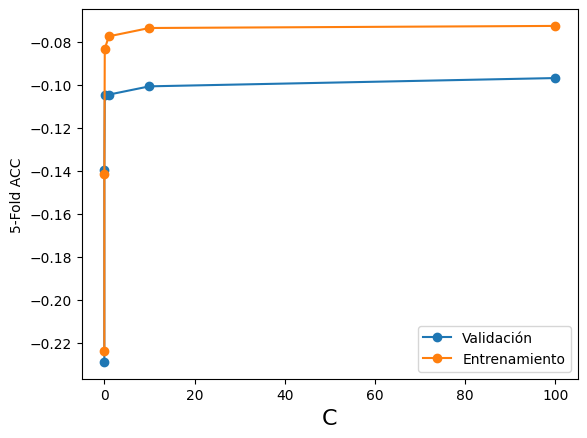

In [17]:
plt.plot(Cs, scores_test, '-o', label='Validación')
plt.plot(Cs, scores_train, '-o', label='Entrenamiento')
plt.xlabel('C', fontsize=16)
plt.ylabel('{}-Fold ACC'.format(n_folds))
plt.legend(loc='best')
plt.show()

In [18]:
cs_opt = grid.best_params_['C']

lr = LogisticRegression(C=cs_opt, random_state = seed)
lr.fit(x_train, y_train)

acc_lr_train = lr.score(x_train, y_train)
acc_lr_test  = lr.score(x_test, y_test)

print('Accuracy (Train): %0.5f' % acc_lr_train)
print('Accuracy (Test): %0.5f' % acc_lr_test)

Accuracy (Train): 0.91085
Accuracy (Test): 0.89655


### DecisionTreeClassifier

Entre los parámetros que controlan la complejidad de los árboles de decisión se ha tenido en cuenta:
- `max_depth`: profuncidad máxima del árbol

In [19]:
#grid search
max_depth = np.arange(1, 16, 1) 
param_grid = {'max_depth': max_depth}  
n_folds = 5

dtc = DecisionTreeClassifier(random_state=seed)

grid_dtc = GridSearchCV(dtc, scoring='accuracy', param_grid=param_grid, cv=5, return_train_score=True)
grid_dtc.fit(x_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid_dtc.best_score_))
print("best parameters: {}".format(grid_dtc.best_params_))

scores_test = np.array(grid_dtc.cv_results_['mean_test_score'])
scores_train = np.array(grid_dtc.cv_results_['mean_train_score'])

best mean cross-validation score: 0.953
best parameters: {'max_depth': 7}


In [20]:
max_depth_opt = grid_dtc.best_params_['max_depth']

dtc = DecisionTreeClassifier(max_depth=max_depth_opt, random_state=seed)
dtc.fit(x_train, y_train)

acc_dtc_train = dtc.score(x_train, y_train)
acc_dtc_test  = dtc.score(x_test, y_test)

print('Accuracy (Train): %0.5f' % acc_dtc_train)
print('Accuracy (Test): %0.5f' % acc_dtc_test)

Accuracy (Train): 1.00000
Accuracy (Test): 0.93103


### Random forest

Los parámetros que se han tenido en cuenta a la hora de iniciar el algoritmo son:
- `n_estimators`: número de árboles construidos.
- `max_features`: número máximo de características a seleccionar aleatoriamente para ajustar cada árbol.

Además de los propios de los árboles de decisión como `max_depth` que se ha optimizado con GridSearchCV como en el modelo anterior.

In [21]:
# grid search
max_depth_arr = range(1, 15)
params = {'max_depth': max_depth_arr}
n_folds = 10

rfc = RandomForestClassifier(random_state=seed, n_estimators=200, max_features='sqrt')

grid_rfc = GridSearchCV(rfc, param_grid=params, cv=n_folds, return_train_score=True)
grid_rfc.fit(x_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid_rfc.best_score_))
print("best parameters: {}".format(grid_rfc.best_params_))

scores_test = np.array(grid_rfc.cv_results_['mean_test_score'])
scores_train = np.array(grid_rfc.cv_results_['mean_train_score'])

best mean cross-validation score: 0.957
best parameters: {'max_depth': 6}


In [22]:
best_max_depth = grid_rfc.best_params_['max_depth']
rfc = RandomForestClassifier(max_depth=best_max_depth, n_estimators=200, max_features='sqrt', random_state=seed)
rfc.fit(x_train, y_train)

acc_rfc_train = rfc.score(x_train, y_train)
acc_rfc_test  = rfc.score(x_test, y_test)

print('Accuracy (Train): %0.5f' % acc_rfc_train)
print('Accuracy (Test): %0.5f' % acc_rfc_test)

Accuracy (Train): 0.99612
Accuracy (Test): 0.95402


### Boosted Trees

Sobre estos tres parámetros se ha realizado una búsqueda conjuntamente mediante GridSearchCV para optimizar el algoritmo de bosques aleatorios:
- `n_estimators`: número etapas de boosting a realizar.
- `learning_rate`: tasa de aprendizaje.
- `max_depth`: profundidad máxima del árbol

In [23]:
# grid search
Niterations = [25, 50, 75, 100, 125, 150, 175, 200, 300]
learningRate = [0.5, 0.1, 0.05, 0.01]
maxDepth = [0.5, 1, 2, 3]
param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate, 'max_depth': maxDepth}
n_folds = 10

gbc = GradientBoostingClassifier(random_state=seed)

grid_gbc = GridSearchCV(gbc, param_grid=param_grid, cv=n_folds, return_train_score=True)
grid_gbc.fit(x_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid_gbc.best_score_))
print("best parameters: {}".format(grid_gbc.best_params_))

best mean cross-validation score: 0.973
best parameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 150}


In [24]:
best_maxDepth = grid_gbc.best_params_['max_depth']
best_learningRate = grid_gbc.best_params_['learning_rate']
best_Niterations = grid_gbc.best_params_['n_estimators']

gbc = GradientBoostingClassifier(learning_rate=best_learningRate, n_estimators=best_Niterations, max_depth=best_maxDepth, random_state=seed)
gbc.fit(x_train, y_train)

acc_gbc_train = gbc.score(x_train, y_train)
acc_gbc_test  = gbc.score(x_test, y_test)

print('Accuracy (Train): %0.5f' % acc_gbc_train)
print('Accuracy (Test): %0.5f' % acc_gbc_test)

Accuracy (Train): 0.98062
Accuracy (Test): 0.94253


### SVM

Los parámetros que se han optimizado de forma simultánea mediante validación cruzada son:
- `C`: inverso a la fuerza de regularización
- `gamma`: distancia que influye en el cálculo de la línea de separación
- `kernel`: tipo de función

In [25]:
# grid search
vectorC = np.logspace(-1, 3, 20)
vectorG = np.logspace(-9, -1, 20)
kernel =  ['rbf', 'poly', 'sigmoid']
param_grid = {'C': vectorC, 'gamma': vectorG, 'kernel': kernel}
n_folds = 5

svc = SVC(random_state=seed)

grid_svc = GridSearchCV(svc, param_grid=param_grid, cv=n_folds)
grid_svc.fit(x_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid_svc.best_score_))
print("best parameters: {}".format(grid_svc.best_params_))

best mean cross-validation score: 0.926
best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}


In [26]:
Copt = grid_svc.best_params_['C']
Gopt = grid_svc.best_params_['gamma']

svc = SVC(kernel='rbf', gamma=Gopt, C=Copt, random_state=seed)
svc.fit(x_train, y_train)

acc_svc_train = svc.score(x_train, y_train)
acc_svc_test  = svc.score(x_test, y_test)

print('Accuracy (Train): %0.5f' % acc_svc_train)
print('Accuracy (Test): %0.5f' % acc_svc_test)

Accuracy (Train): 0.72093
Accuracy (Test): 0.72414


## Comparación de modelos

En este apartado se crea un DataFrame con las precisiones de `accuracy_train` y `accuracy_test` para cada modelo y se representa en un diagrama de barras de cada puntuación para escoger aquel que tenga una mejor precisión en prueba.

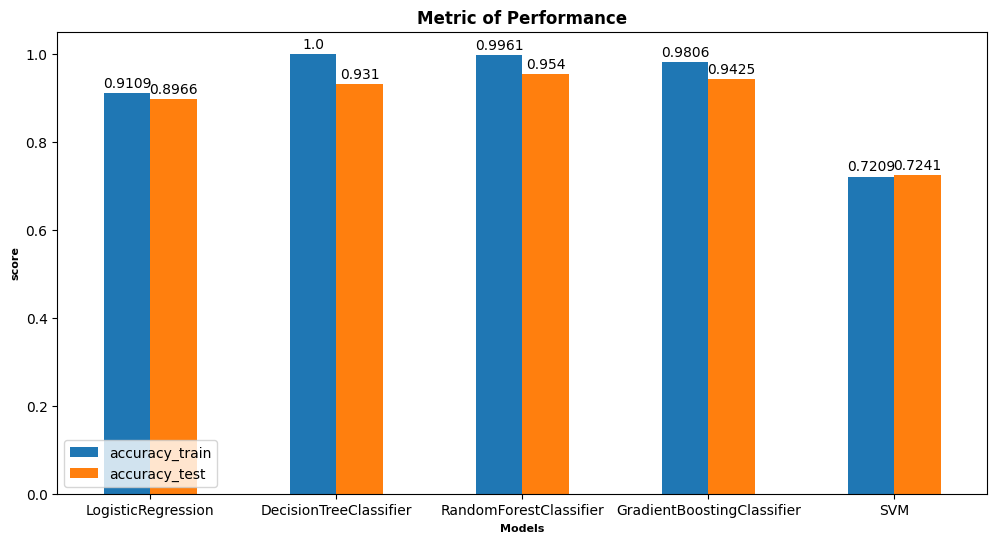

In [27]:
data = {
    'Modelo': ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'SVM'],
    'accuracy_train': [acc_lr_train, acc_dtc_train, acc_rfc_train, acc_gbc_train, acc_svc_train],
    'accuracy_test': [acc_lr_test, acc_dtc_test, acc_rfc_test, acc_gbc_test, acc_svc_test]
}

results = pd.DataFrame(data)

plots = results.plot(x='Modelo', y=['accuracy_train', 'accuracy_test'], kind='bar', figsize=(12, 6))
plt.xticks(rotation=360)
#plt.grid(axis='y')
plt.legend(loc='lower left')
plt.title("Metric of Performance", fontsize = 12, fontweight = "bold", color = "black")
plt.ylabel("score", fontsize = 8, fontweight = "bold", color = "black")
plt.xlabel("Models", fontsize = 8, fontweight = "bold", color = "black")


for p in plots.patches:
   plots.annotate(
        # Valor de la precisión (redondeado a dos decimales)
        str(round(p.get_height(), 4)),
        # Coordenadas del texto (centro de la barra)
        (p.get_x() + p.get_width() / 2., p.get_height()),
        # Alineación horizontal del texto (centro)
        ha='center',
        # Alineación vertical del texto (centro)
        va='center',
        # Desplazamiento de las coordenadas del texto (10 puntos arriba)
        xytext=(0, 7),
        # Tipo de coordenadas para el desplazamiento (puntos)
        textcoords='offset points'
    )

plt.show()


## Resultados

### Predicciones

Una vez escogido el mejor modelo de entre los cinco, se van a calcular las predicciones en los datos reservados para test.

In [28]:
y_test_pred = rfc.predict(x_test)
y_test_pred

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1])

In [29]:
y_test_pred_count = pd.Series(y_test_pred)
y_test_pred_count.value_counts()

0    65
1    22
Name: count, dtype: int64

### Classification report

Se construye un informe de texto que muestre las principales métricas de clasificación.

In [30]:
print(classification_report(y_test, y_test_pred, target_names=['No Recurred', 'Recurred']))

              precision    recall  f1-score   support

 No Recurred       0.95      0.98      0.97        63
    Recurred       0.95      0.88      0.91        24

    accuracy                           0.95        87
   macro avg       0.95      0.93      0.94        87
weighted avg       0.95      0.95      0.95        87



### Matriz de confusion

Se crea primero la matriz de confusión y luego se representa indicando las etiquetas de la variable predicha.

In [31]:
cnf_matrix = confusion_matrix(y_test, y_test_pred)
cnf_matrix

array([[62,  1],
       [ 3, 21]], dtype=int64)

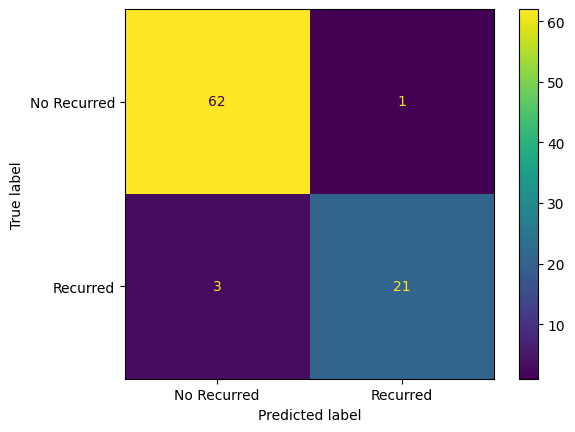

In [32]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels = ["No Recurred", "Recurred"])

cm_display.plot()
plt.show()

### Selección de características importantes

Al igual que con todos los algoritmos de árboles de decisión, 'RandomForestClassifier' proporciona información sobre la importancia de cada característica durante el entrenamiento. Aunque sería posible eliminar aquellas características que no superen un umbral mínimo de importancia, conllevaría la pérdida de una cantidad significativa de información. Esto podría mejorar el rendimiento del modelo en ciertos casos, pero no sería apropiado para la predicción de nuevos datos no conocidos.

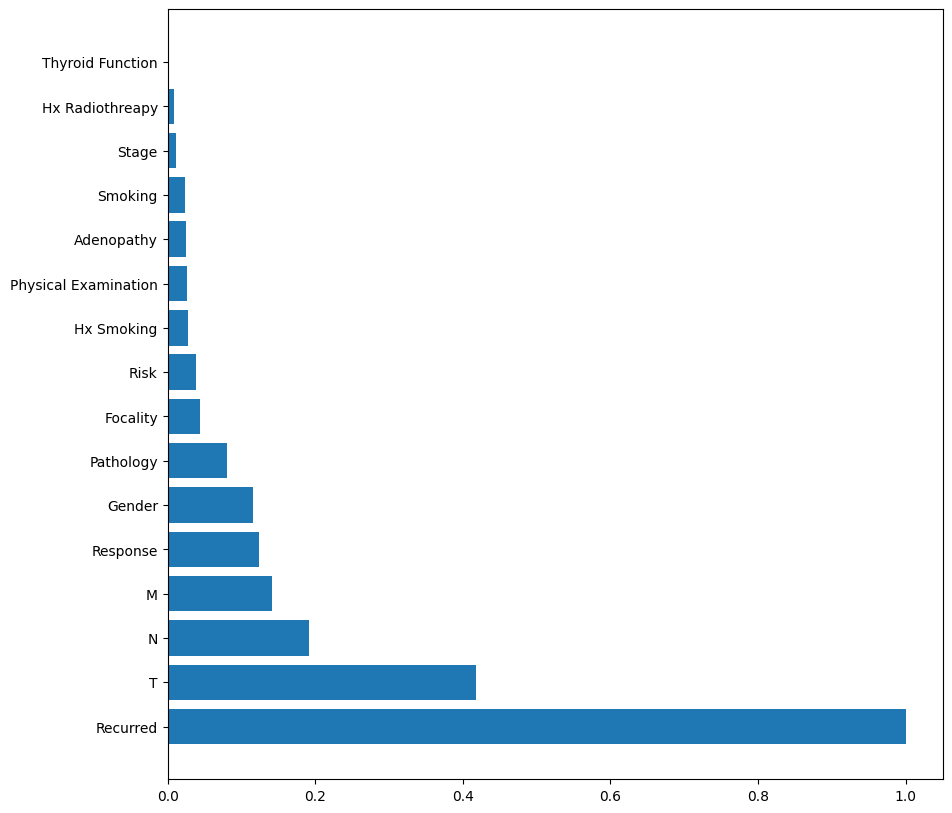

In [33]:
importances = rfc.feature_importances_
importances = importances / np.max(importances)
feature_names = df.columns[1:]

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 10))
plt.barh(range(x_train.shape[1]), importances[indices])
plt.yticks(range(x_train.shape[1]), feature_names[indices])
plt.show()

## Diagnóstico

Se importa el dataset con los nuevos pacientes sin etiquetar.

In [44]:
df_diag = pd.read_csv("diagnostico.csv")

In [45]:
df_diag.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response
0,51,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
1,49,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
2,76,F,No,No,No,Clinical Hypothyroidism,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
3,40,F,No,Yes,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
4,44,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate


In [46]:
df_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   38 non-null     int64 
 1   Gender                38 non-null     object
 2   Smoking               38 non-null     object
 3   Hx Smoking            38 non-null     object
 4   Hx Radiothreapy       38 non-null     object
 5   Thyroid Function      38 non-null     object
 6   Physical Examination  38 non-null     object
 7   Adenopathy            38 non-null     object
 8   Pathology             38 non-null     object
 9   Focality              38 non-null     object
 10  Risk                  38 non-null     object
 11  T                     38 non-null     object
 12  N                     38 non-null     object
 13  M                     38 non-null     object
 14  Stage                 38 non-null     object
 15  Response              38 non-null     obje

Se crea una copia del Dataframe original para en este codificar las variables categóricas de las numéricas, ya que es necesario para calcular la predicción.

In [47]:
# Creamos una copia del Dataframe para no modificar los datos originales del dataset
df_diag_copy = df_diag.copy()

# Separamos las variables categóricas de las númericas
categorical_features = df_diag.columns[1:]


le = LabelEncoder()

for i in categorical_features:
    df_diag_copy[i] = le.fit_transform(df_diag[i])

In [48]:
df_diag_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   38 non-null     int64
 1   Gender                38 non-null     int32
 2   Smoking               38 non-null     int32
 3   Hx Smoking            38 non-null     int32
 4   Hx Radiothreapy       38 non-null     int32
 5   Thyroid Function      38 non-null     int32
 6   Physical Examination  38 non-null     int32
 7   Adenopathy            38 non-null     int32
 8   Pathology             38 non-null     int32
 9   Focality              38 non-null     int32
 10  Risk                  38 non-null     int32
 11  T                     38 non-null     int32
 12  N                     38 non-null     int32
 13  M                     38 non-null     int32
 14  Stage                 38 non-null     int32
 15  Response              38 non-null     int32
dtypes: int32(1

Se aplica el mejor modelo al dataframe con los nuevos pacientes.

In [49]:
predicted = rfc.predict(df_diag_copy)
predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Esstas predicciones se guardan en una serie de Pandas.

In [50]:
predictions = pd.Series(predicted)
predictions

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    1
22    0
23    0
24    0
25    0
26    0
27    0
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
dtype: int32

Se combinan los resultados de la predicción en un nuevo dataframe denominado diagnóstico. Para ello, se añade una nueva columna al dataframe original con la serie de pandas recién creada.

In [51]:
diagnostico = df_diag.copy()
diagnostico["Diagnosis"] = predictions
diagnostico.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Diagnosis'],
      dtype='object')

In [52]:
diagnostico.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Diagnosis
0,51,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
1,49,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
2,76,F,No,No,No,Clinical Hypothyroidism,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
3,40,F,No,Yes,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
4,44,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,0


Por último, se extraen los resultados del diagnóstico en formato '.csv'.

In [53]:
diagnostico.to_csv("prediccion.csv")